In [2]:
import pandas as pd
import tensorflow
import numpy as np
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.applications import MobileNetV2

In [3]:
base_model = MobileNetV2(include_top=False, weights = "imagenet", input_shape = (224, 224, 3))

In [4]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='sigmoid'))

In [5]:
data = pd.read_csv(r"C:\Users\HP\Downloads\archive (1)\HAM10000_metadata.csv")
data['image_full_name'] = data['image_id']+'.jpg'
X = data[['image_full_name', 'dx', 'lesion_id']]

In [6]:
X.sample(5)

,image_full_name,dx,lesion_id
803,ISIC_0026248.jpg,bkl,HAM_0004224
7007,ISIC_0028534.jpg,nv,HAM_0003653
4575,ISIC_0030495.jpg,nv,HAM_0003111
8007,ISIC_0034108.jpg,nv,HAM_0005997
1754,ISIC_0033081.jpg,mel,HAM_0007583


In [7]:
from sklearn.model_selection import train_test_split
Y = X.pop('dx').to_frame()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.17, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state = 42)

In [8]:
train = pd.concat([X_train, y_train], axis = 1)
val = pd.concat([X_val, y_val], axis=1)
test=pd.concat([X_test, y_test], axis = 1)

In [9]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_train = encoder.transform(val['dx'])
val['label'] = name_as_indexes_train

In [10]:
encoder = LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_test = encoder.transform(val['dx'])
val['label'] = name_as_indexes_test

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rest of your code remains the same
train_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=10,
                                     zoom_range=0.1,
                                     width_shift_range=0.0,
                                     height_shift_range=0.00)


In [12]:
train_data= train_generator.flow_from_dataframe(dataframe=train,x_col="image_full_name",y_col="dx",
                                                batch_size=32,directory=r"C:\Users\HP\Downloads\archive (1)\HAM1000_images\HAM1000_images",
                                                shuffle=True,class_mode="categorical",target_size=(224,224))

Found 6898 validated image filenames belonging to 7 classes.


In [13]:
test_generator=ImageDataGenerator(rescale = 1./255,rotation_range=10,  
                                     zoom_range = 0.1, 
                                     width_shift_range=0.0,  height_shift_range=0.02)

In [16]:
test_data= test_generator.flow_from_dataframe(dataframe=test,x_col="image_full_name",y_col="dx",
                                              directory=r"C:\Users\HP\Downloads\archive (1)\HAM1000_images\HAM1000_images",
                                              shuffle=False,batch_size=1,class_mode=None,target_size=(224,224))

Found 1703 validated image filenames.


In [17]:
val_data=test_generator.flow_from_dataframe(dataframe=val,x_col="image_full_name",y_col="dx",
                                            directory=r"C:\Users\HP\Downloads\archive (1)\HAM1000_images\HAM1000_images",
                                            batch_size=64,shuffle=False,class_mode="categorical",target_size=(224,224))

Found 1414 validated image filenames belonging to 7 classes.


In [18]:
from keras.callbacks import ReduceLROnPlateau
learning_control = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=.5, min_lr=0.0001)

In [19]:
from keras.optimizers import Adam,SGD
sgd = optimizers.SGD(learning_rate = 0.01, clipvalue = 0.5)
model.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=["accuracy"])

In [72]:
history = model.fit(
    x=train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    epochs=30,
    callbacks=[learning_control]
)

Epoch 1/30
 11/215 [>.............................] - ETA: 15:38 - loss: 0.0661 - accuracy: 0.9830

KeyboardInterrupt: 

In [21]:
model.save('model.h5')

In [54]:
import pickle

# Save the trained model to a pickle file
model_filename = 'model.pkl'

with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)

print(f"Model saved as {model_filename}")


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv2d
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\flatten
......vars
...layers\functional
......vars
...layers\functional\layers\add
......vars
...layers\functional\layers\add_1
......vars
...layers\functional\layers\add_2
......vars
...layers\functional\layers\add_3
......vars
...layers\functional\layers\add_4
......vars
...layers\functional\layers\add_5
......vars
...layers\functional\layers\add_6
......vars
...layers\functional\layers\add_7
......vars
...layers\functional\layers\add_8
......vars
...layers\functional\layers\add_9
......vars
...layers\functional\layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\functional\layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...laye

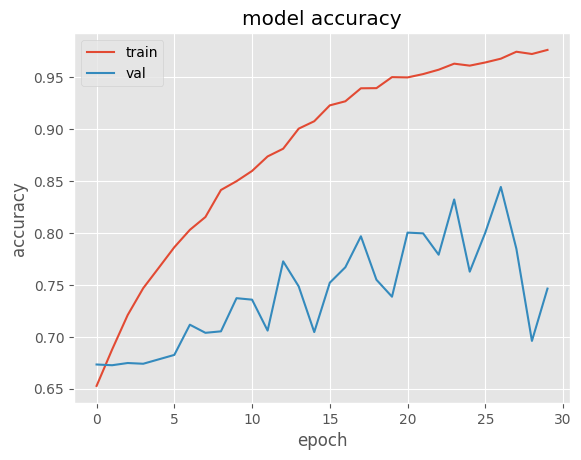

In [32]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

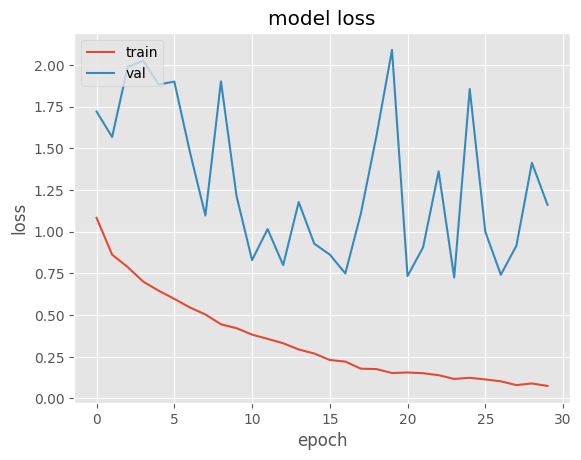

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

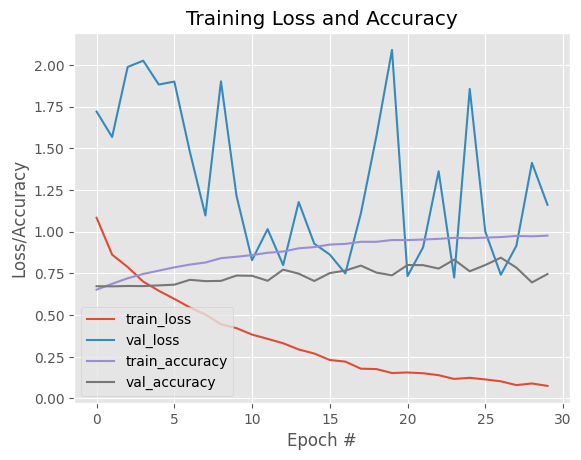

In [35]:
N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [36]:
test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

   4/1703 [..............................] - ETA: 38s 

C:\Users\HP\AppData\Local\Temp\ipykernel_23580\1044357436.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)


1703/1703 [==============================] - 38s 22ms/step


In [52]:
c=np.where(y_pred == name_as_indexes_test)

C:\Users\HP\AppData\Local\Temp\ipykernel_23580\4108884144.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  c=np.where(y_pred == name_as_indexes_test)


In [48]:
import numpy as np

# Assuming y_pred and name_as_indexes_test are numpy arrays with different shapes
# Filter y_pred to match the number of elements in name_as_indexes_test
equal_indices = np.arange(len(name_as_indexes_test))

# Now, 'equal_indices' contains the indices that align with the shape of name_as_indexes_test


In [49]:
equal_indices = np.where(y_pred == name_as_indexes_test)[0]

C:\Users\HP\AppData\Local\Temp\ipykernel_23580\2692802433.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  equal_indices = np.where(y_pred == name_as_indexes_test)[0]


In [50]:
import numpy as np

# Assuming y_pred and name_as_indexes_test are numpy arrays with the same length
if y_pred.shape == name_as_indexes_test.shape:
    equal_indices = np.where(y_pred == name_as_indexes_test)[0]
else:
    # Handle the case when the shapes are different (e.g., by trimming or aligning the arrays)
    print("Shapes of y_pred and name_as_indexes_test are not the same.")

# Now, 'equal_indices' contains the indices where the arrays are equal (if shapes are aligned)


Shapes of y_pred and name_as_indexes_test are not the same.


In [53]:
np.count_nonzero(c)

0

In [41]:
print("Test Accuracy :",(np.count_nonzero(c)/len(name_as_indexes_test))*100)

Test Accuracy : 0.0


In [ ]:
# model.save("model.h5")

In [56]:
import pickle
from keras.models import load_model

model = load_model('model.h5')  # Load the Keras model
model_filename = 'model.pkl'

with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv2d
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\flatten
......vars
...layers\functional
......vars
...layers\functional\layers\add
......vars
...layers\functional\layers\add_1
......vars
...layers\functional\layers\add_2
......vars
...layers\functional\layers\add_3
......vars
...layers\functional\layers\add_4
......vars
...layers\functional\layers\add_5
......vars
...layers\functional\layers\add_6
......vars
...layers\functional\layers\add_7
......vars
...layers\functional\layers\add_8
......vars
...layers\functional\layers\add_9
......vars
...layers\functional\layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\functional\layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...laye

In [68]:
from keras.models import load_model
import numpy as np
import cv2
import os

# Load the saved model
model_filename = 'model.h5'  # Replace with the correct model file path
loaded_model = load_model(model_filename)

# Define a function to preprocess an image
def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found at: {image_path}")

    # Load the image using OpenCV
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError(f"Unable to load image from: {image_path}")

    # Resize the image to the same size as the model was trained on (224x224)
    image = cv2.resize(image, (224, 224))
    # Convert the image to a numpy array
    image = np.array(image)
    # Normalize the image pixel values to the range [0, 1]
    image = image / 255.0
    # Expand the dimensions to match the input shape of the model (add batch dimension)
    image = np.expand_dims(image, axis=0)
    return image

# Define a function to predict the class of an image
def predict_image_class(image_path):
    try:
        # Preprocess the image
        preprocessed_image = preprocess_image(image_path)
        # Use the loaded model to make a prediction
        predicted_probabilities = loaded_model.predict(preprocessed_image)
        # Get the class with the highest probability
        predicted_class = np.argmax(predicted_probabilities, axis=1)
        return predicted_class[0]
    except FileNotFoundError as e:
        return f"Error: File not found - {e.filename}"
    except ValueError as e:
        return f"Error: Unable to load image - {e}"
    except Exception as e:
        return f"Error: {str(e)}"

# Example usage:
image_path = r"C:\Users\HP\Downloads\archive (1)\HAM1000_images\HAM1000_images\ISIC_0024313.jpg"  # Replace with the path to your image
predicted_class_index = predict_image_class(image_path)
print(f'Predicted class index: {predicted_class_index}')


1/1 [==============================] - 1s 629ms/step
Predicted class index: 6


In [80]:
from keras.models import load_model
import numpy as np
import cv2
import os

# Load the saved model
model_filename = 'model.h5'  # Replace with the correct model file path
loaded_model = load_model(model_filename)

# Define a list of class labels
class_labels = ["Actinic keratoses and intraepithelial carcinomae(akiec)", "basal cell carcinoma(bcc)", "Bkl (benign keratosis)", "Df(dermatofibroma)", "melanoma (mel)", "melanocytic nevi (nv)", "Vasc(vascular skinesions)"]  # Replace with your class labels

# Define a function to preprocess an image
def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found at: {image_path}")

    # Load the image using OpenCV
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError(f"Unable to load image from: {image_path}")

    # Resize the image to the same size as the model was trained on (224x224)
    image = cv2.resize(image, (224, 224))
    # Convert the image to a numpy array
    image = np.array(image)
    # Normalize the image pixel values to the range [0, 1]
    image = image / 255.0
    # Expand the dimensions to match the input shape of the model (add batch dimension)
    image = np.expand_dims(image, axis=0)
    return image

# Define a function to predict the class of an image
def predict_image_class(image_path):
    try:
        # Preprocess the image
        preprocessed_image = preprocess_image(image_path)
        # Use the loaded model to make a prediction
        predicted_probabilities = loaded_model.predict(preprocessed_image)
        # Get the class with the highest probability
        predicted_class_index = np.argmax(predicted_probabilities, axis=1)
        # Get the class name from the list of class labels
        predicted_class_name = class_labels[predicted_class_index[0]]
        return predicted_class_name
    except FileNotFoundError as e:
        return f"Error: File not found - {e.filename}"
    except ValueError as e:
        return f"Error: Unable to load image - {e}"
    except Exception as e:
        return f"Error: {str(e)}"

# Example usage:
image_path = r"C:\Users\HP\Downloads\archive (1)\HAM1000_images\HAM1000_images\ISIC_0024313.jpg"  # Replace with the path to your image
predicted_class_name = predict_image_class(image_path)
print(f'Predicted class name: {predicted_class_name}')


1/1 [==============================] - 1s 1s/step
Predicted class name: Vasc(vascular skinesions)


In [ ]:
"C:\Users\HP\Downloads\archive (1)\HAM1000_images\HAM1000_images\ISIC_0034305.jpg"